In [110]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
from matplotlib import rcParams
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches 
import seaborn as sns
from collections import defaultdict
from sequencing_tools.viz_tools import okabeito_palette, \
                        simpsons_palette, \
                        RNA_base_from_picard, \
                        RNA_cov_from_picard, \
                        color_encoder
from collections import defaultdict
import re
import glob
import os
from plotting_utils import label_sample, rename_sample, \
                        label_ce, rna_type_ce, label_order, \
                        figure_path

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [111]:
def genome_rna():
    def change_type(x):
        if x == 'lncRNA':
            return 'Other ncRNA'
        else:
            return x
        
    return pd.read_table('/stor/work/Lambowitz/ref/hg19/new_genes/theoretical/theoretical_base_count.tsv') \
        .assign(grouped_type = lambda d: d.rna_type.map(lambda x: x.strip('b').strip("'"))) \
        .assign(grouped_type = lambda d: d.grouped_type.map(change_type))\
        .query('grouped_type != "other"')\
        .assign(base_fraction = lambda d: d.base_fraction / d.base_fraction.sum() * 100)\
        .pipe(pd.pivot_table, columns = 'grouped_type', values='base_fraction', aggfunc=np.sum) \
        .assign(treatment = 'Genome')\
        .set_index('treatment')

In [112]:
filter_feature = 'No features'
dedup_df \
        .filter(regex = 'type|Qcf|QCF|sim')\
        .assign(grouped_type = lambda d: np.where(d.grouped_type == "rDNA", 'rRNA', d.grouped_type))\
        .assign(grouped_type = lambda d: np.where(d.grouped_type == "vaultRNA",'Vault RNA', d.grouped_type))\
        .groupby('grouped_type')\
        .sum() \
        .pipe(lambda d: d[d.columns[~d.columns.str.contains('anti')]])\
        .pipe(lambda d: d[d.columns[d.columns.str.contains('dedup')]]) \
        .reset_index()\
        .pipe(pd.melt, id_vars = ['grouped_type']) \
        .assign(treatment = lambda d: d.variable.map(label_sample)) \
        .groupby(['grouped_type','variable','treatment'], as_index=False)\
        .agg({'value':'sum'}) \
        .query('grouped_type != "%s"' %filter_feature)\
        .pipe(lambda d: d[d.treatment.str.contains('Exo|Na|DN|Untre|sim')])\
        .assign(value = lambda d: d.groupby('variable')['value'].transform(lambda x: 100*x/x.sum()))\
        .pipe(pd.pivot_table, index = 'variable', 
             columns = 'grouped_type',
             values = 'value')\
        .reset_index() \
        .sort_values('Protein coding')

grouped_type,variable,Antisense,Mt,Other ncRNA,Other sncRNA,Protein coding,Repeats,Vault RNA,miRNA,rRNA,snoRNA,tRNA
3,Qcf11_R1_001:dedup:sense,0.006471,0.093929,0.039697,33.488730,0.210003,0.345563,0.000000,0.003300,6.467876,0.014138,59.330293
7,Qcf7_R1_001:dedup:sense,0.017021,0.000168,0.069632,7.349782,0.302279,0.804473,0.000000,0.006122,8.760426,0.013153,82.676944
8,Qcf8_R1_001:dedup:sense,0.023436,0.000133,0.067195,5.135937,0.375242,0.887008,0.000000,0.003380,6.071862,0.005737,87.430070
5,Qcf5_R1_001:dedup:sense,0.023033,0.000252,0.078422,7.749709,0.392364,0.872172,0.000000,0.006199,16.281577,0.015221,74.581050
4,Qcf4_R1_001:dedup:sense,0.021971,0.000041,0.085584,7.876352,0.406934,1.019246,0.000000,0.004600,17.005046,0.012402,73.567824
0,QCF1_R1_001:dedup:sense,0.026707,0.000065,0.096635,6.793274,0.414874,1.195930,0.000000,0.009380,9.166536,0.012051,82.284548
9,Qcf9_R1_001:dedup:sense,0.028651,0.000045,0.080878,4.253686,0.450063,1.149139,0.000000,0.003638,7.302503,0.005524,86.725873
1,QCF2_R1_001:dedup:sense,0.030779,0.000056,0.108982,6.546509,0.463577,1.461714,0.000000,0.013908,9.275274,0.013824,82.085376
6,Qcf6_SS_R1_001:dedup:sense,0.029998,0.000041,0.099664,8.471762,0.514755,1.026437,0.000000,0.004385,20.140325,0.013032,69.699601
2,Qcf10_R1_001:dedup:sense,0.031210,0.000192,0.096554,5.866704,0.526910,1.352872,0.000000,0.002617,7.147074,0.008004,84.967863


## plot count function

In [113]:
def plot_count(ax, feature_only=True):
    dedup_df = pd.read_table('/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/Counts/all_counts/spreaded_all_counts.tsv')


    filter_feature = 'No features' if feature_only else ''
    
    countplot_df = dedup_df \
        .filter(regex = 'type|Qcf|QCF|sim')\
        .assign(grouped_type = lambda d: np.where(d.grouped_type == "rDNA", 'rRNA', d.grouped_type))\
        .assign(grouped_type = lambda d: np.where(d.grouped_type == "vaultRNA",'Vault RNA', d.grouped_type))\
        .groupby('grouped_type')\
        .sum() \
        .pipe(lambda d: d[d.columns[~d.columns.str.contains('anti')]])\
        .pipe(lambda d: d[d.columns[d.columns.str.contains('dedup')]]) \
        .reset_index()\
        .pipe(pd.melt, id_vars = ['grouped_type']) \
        .assign(treatment = lambda d: d.variable.map(label_sample)) \
        .groupby(['grouped_type','treatment'], as_index=False)\
        .agg({'value':'sum'}) \
        .query('grouped_type != "%s"' %filter_feature)\
        .pipe(lambda d: d[d.treatment.str.contains('Exo|Na|DN|Untre|sim')])\
        .assign(value = lambda d: d.groupby('treatment')['value'].transform(lambda x: 100*x/x.sum()))\
        .pipe(pd.pivot_table, index = 'treatment', 
             columns = 'grouped_type',
             values = 'value')\
        .reset_index() \
        .sort_values('treatment')\
        .set_index('treatment')\
        .pipe(lambda d: d.reindex(sorted(d.columns), axis=1))
    
    colors = rna_type_ce.transform(countplot_df.columns)
    countplot_df\
        .reindex(index=label_order)\
        .plot\
        .bar(stacked=True, 
             color = colors, 
              ax = ax,
             width = 0.8)
    xt = [xt.set_text(xt.get_text()) for xt in ax.get_xticklabels()]
    ax.set_xticklabels(ax.get_xticklabels(), 
                       rotation = 70, ha = 'right',
                      rotation_mode="anchor")
    ax.legend()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], 
              bbox_to_anchor = (0.9,1), fontsize = 15,
             frameon=False)
    ax.set_xlabel('')
    ax.set_ylabel('Read pairs (%)')
    sns.despine()

# insert size

In [120]:
def plot_insert(ax):
    insert_path = '/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/fragment_sizes'
    data_files = glob.glob(insert_path + '/*.tsv')
    df = {os.path.basename(data_file):pd.read_table(data_file) for data_file in data_files}
    df = pd.concat([val.assign(label = key) for key, val in df.items()]) \
        .assign(label = lambda d: d.label.str.replace('.tsv','').str.capitalize())\
        .assign(label = lambda d: np.where(d.label == 'Polya','PolyA-selected', d.label))\
        .sort_values('isize') \
        .query('isize < 400') \
        .assign(size_fraction = lambda d: d.groupby('label')['size_count'].transform(lambda x: 100* x/ x.sum()))\
        .pipe(lambda d: d[d.label.str.contains('Alk|Un|[Ee]xo|All')]) \
        .assign(label = lambda d: d.label.map(label_sample)) 
    
    for lab, lab_df in df.groupby('label'):
        ax.plot(lab_df['isize'], 
                 lab_df['size_fraction'], 
                 linewidth=3,
                 label = lab,
                 color = label_ce.encoder[lab])
        
    ax.legend(title= ' ', 
             fontsize = 15, 
             frameon=False, 
             bbox_to_anchor = (0.6,0.8))
    ax.set_xlabel('Read span (nt)')
    ax.set_ylabel('Read pairs (%)')
    
    
    for i, label in enumerate(ax.get_xticklabels()):
        label.set_x(label.get_position()[0] + 1)

In [121]:
metric_path = '/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/merged_bam/filtered_bam'
metrics = glob.glob(metric_path + '/*.filtered.RNA_Metrics')

def read_metric(metric):
    return pd.read_table(metric, skiprows=6, nrows=1)\
        .pipe(pd.melt) \
        .pipe(lambda d: d[d.variable.str.contains('TRANSCRIPT_STRAND_')])\
        .pipe(lambda d: d[d.variable.str.contains('PCT')]) 

def plot_strand(ax):
    strand_df = {os.path.basename(metric).split('.')[0]: read_metric(metric) for metric in metrics}
    strand_df = pd.concat([d.assign(samplename = k) for k, d in strand_df.items()])\
        .pipe(lambda d: d[d.samplename.str.contains('[uU]nt|unf|[Aa]lka|[eE]xo|sim')])\
        .assign(samplename = lambda d: d.samplename.map(label_sample))\
        .assign(variable = lambda d: np.where(d.variable.str.contains('R1'), 'Sense','Antisense'))\
        .assign(value = lambda d: d['value'] * 100)\
        .pipe(pd.pivot_table, index='samplename', columns = 'variable', values = 'value')\
        .reindex(index=label_order)\
        .plot.bar(stacked=True, ax = ax, width = 0.8)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 70, ha = 'right',rotation_mode="anchor")
    ax.legend()
    ax.set_xlabel('')
    ax.set_ylabel('Protein-coding bases (%)')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], 
              bbox_to_anchor = (.9,1), fontsize = 15,
             frameon=False)
    
    
def plot_coding_bases(ax):
    RNA_base_from_picard(metrics) \
        .assign(var_count = lambda d: d.var_count*100)\
        .pipe(lambda d: d[d.samplename.str.contains('[eE]xo|[uU]nt|unf|[Aa]lka|sim')])\
        .assign(samplename = lambda d: d.samplename.str.split('.',expand=True).iloc[:,0].map(label_sample))\
        .assign(variable = lambda d: d.variable.str.replace('Utr','UTR'))\
        .assign(variable = lambda d: d.variable.str.replace(' bases',''))\
        .pipe(pd.pivot_table, columns = 'variable', index='samplename', values = 'var_count')\
        .reindex(index=label_order)\
        .plot.bar(stacked=True, width = 0.8, color = simpsons_palette(), ax = ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 70, ha = 'right',rotation_mode="anchor")
    ax.set_ylabel('Protein-coding bases (%)')
    ax.set_xlabel('')
    ax.legend(title = '', bbox_to_anchor = (1,1))
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], bbox_to_anchor = (0.9,1), 
              fontsize = 15, frameon=False)

ValueError: No objects to concatenate

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


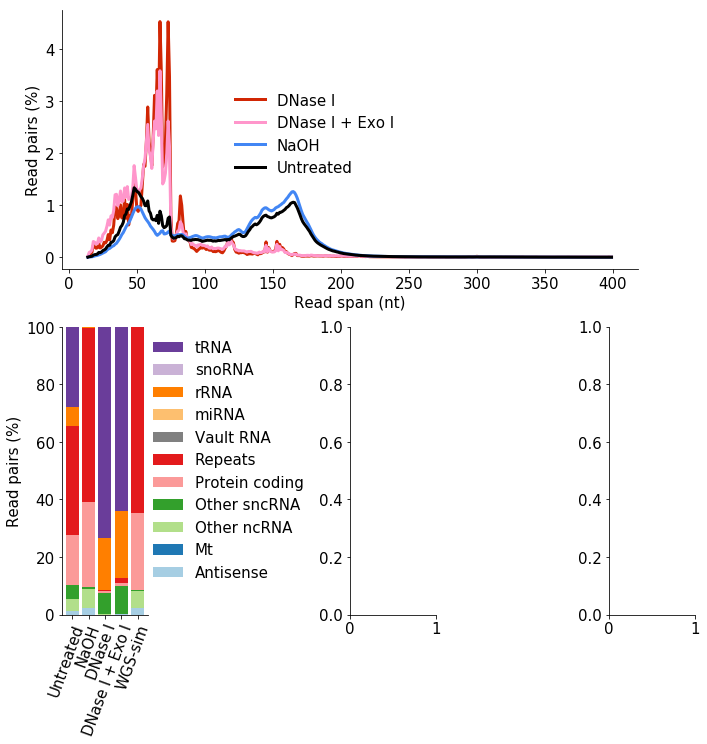

In [122]:
fig = plt.figure(figsize = (8,8))
ax_insert = fig.add_axes([0,0.6,1,0.45])
plot_insert(ax_insert)



# lower
ax_frag_dist = fig.add_axes([0,0,0.15,0.5])
ax_strand = fig.add_axes([0.5,0,0.15,0.5])
ax_coding = fig.add_axes([0.95,0,0.15,0.5])


#plot_count(ax_frag_dist, feature_only=False)
plot_count(ax_frag_dist, feature_only=True)
plot_strand(ax_strand)
plot_coding_bases(ax_coding)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


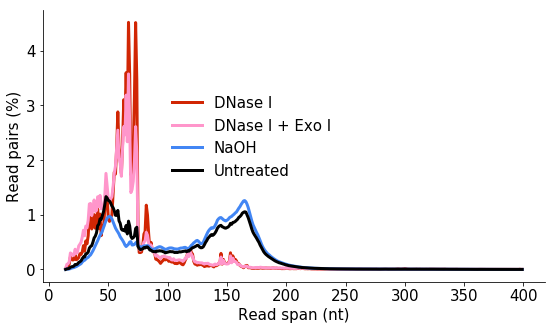

In [32]:
fig = plt.figure(figsize = (9,5))
ax_insert = fig.add_subplot(111)
plot_insert(ax_insert)
sns.despine()
fig.savefig(figure_path + '/insert_plots.pdf', bbox_inches = 'tight')

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


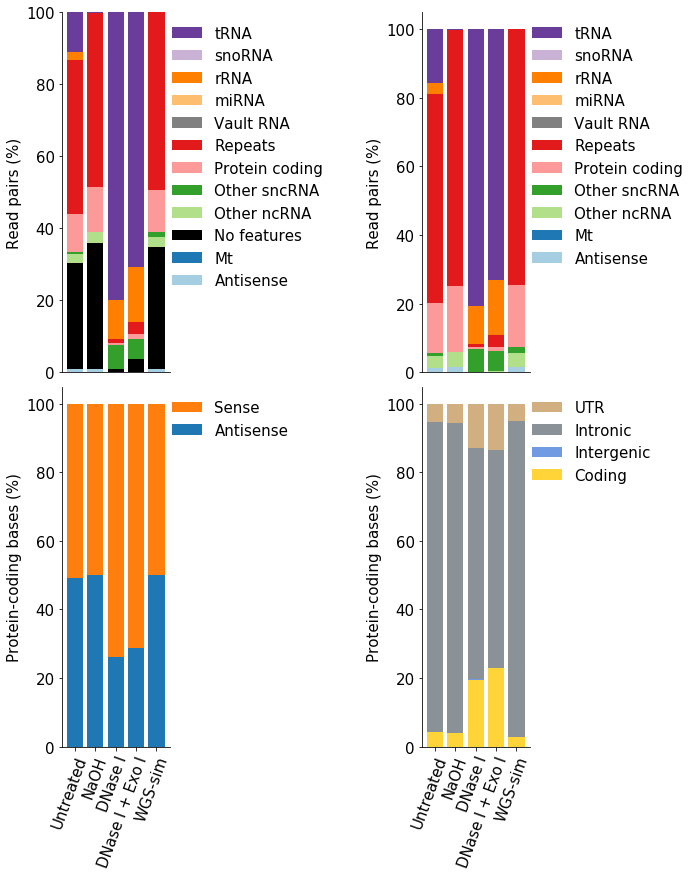

In [33]:
#fig = plt.figure(figsize = (10,8))
#ax_frag_dist = fig.add_axes([0,0,0.15,0.5])
#ax_frag_dist_feature_only = fig.add_axes([0.5,0,0.15,0.5])
#ax_strand = fig.add_axes([1,0,0.15,0.5])
#ax_coding = fig.add_axes([1.4,0,0.15,0.5])

fig = plt.figure(figsize = (10,10))
ax_frag_dist = fig.add_axes([0,0.52,0.15,0.5])
ax_frag_dist_feature_only = fig.add_axes([0.5,0.52,0.15,0.5])
ax_strand = fig.add_axes([0,0,0.15,0.5])
ax_coding = fig.add_axes([0.5,0, 0.15, 0.5])


plot_count(ax_frag_dist, feature_only=False)
ax_frag_dist.xaxis.set_visible(False)
plot_count(ax_frag_dist_feature_only, feature_only=True)
ax_frag_dist_feature_only.xaxis.set_visible(False)
plot_strand(ax_strand)
plot_coding_bases(ax_coding)
#fig.tight_layout()
fig.savefig(figure_path + '/fragment_plots.pdf', bbox_inches = 'tight')

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Text(0.1,0.86,"Pearson's $\\rho$")

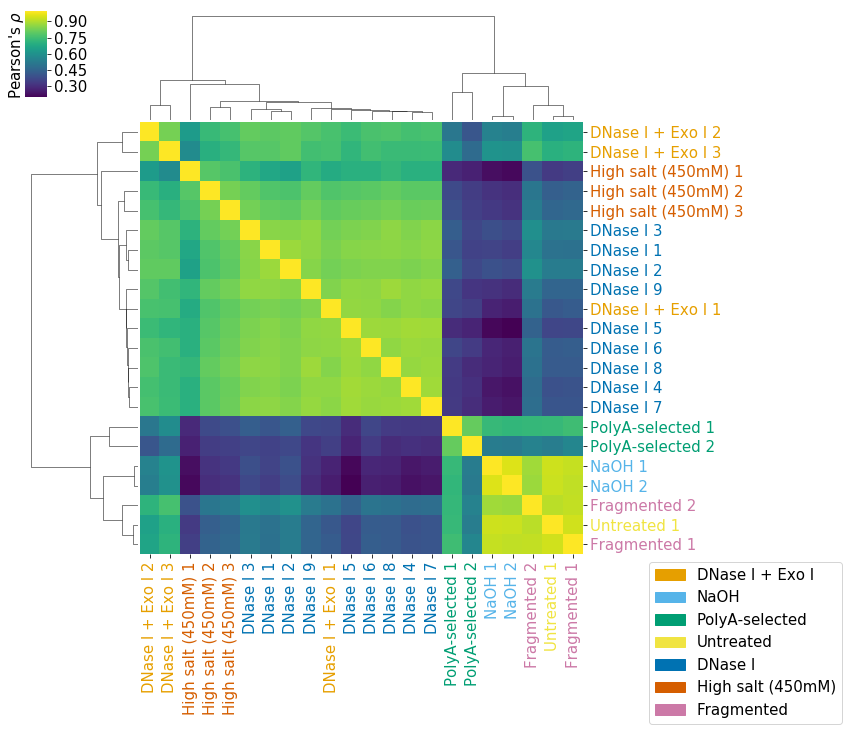

In [21]:
from collections import defaultdict
dedup_df = pd.read_table('/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/Counts/all_counts/spreaded_all_counts.tsv')
cor_df = np.log(dedup_df\
                    .filter(regex = 'Qcf|QCF')\
                    .filter(regex="dedup:sense") \
                    .pipe(lambda d: d+1))
cor_df.columns = rename_sample(cor_df.columns)
cor_df = cor_df.corr(method='pearson')
p = sns.clustermap(cor_df, cmap = 'viridis')
ax = p.ax_heatmap
xt = ax.set_xticks(range(cor_df.shape[0]))
yt = ax.set_yticks(range(cor_df.shape[1]))
xt = ax.set_xticklabels(cor_df.columns[p.dendrogram_col.reordered_ind])
yt = ax.set_yticklabels(cor_df.index[p.dendrogram_row.reordered_ind])

yt = ax.set_yticks(np.arange(cor_df.shape[1])+0.5)
xt = ax.set_xticks(np.arange(cor_df.shape[0])+0.5)

ce = color_encoder()
ce.fit(cor_df.columns.str.replace(' [0-9]+$',''), 
                 okabeito_palette())
for xt in ax.get_xmajorticklabels():
    color = ce.encoder[re.sub(' [0-9]+$','', xt.get_text())]
    xt.set_color(color)
    
for yt in ax.get_ymajorticklabels():
    color = ce.encoder[re.sub(' [0-9]+$','', yt.get_text())]
    yt.set_color(color)

pat = [mpatches.Patch(color=col, label=lab) for lab, col in ce.encoder.items()]
ax.legend(handles=pat, bbox_to_anchor = (1.6,0.), fontsize=15)
p.fig.text(0.1, 0.86, r"Pearson's $\rho$", rotation = 90, fontsize=15)

In [ ]:
strand_df = {os.path.basename(metric).split('.')[0]: read_metric(metric) for metric in metrics}
pd.concat([d.assign(samplename = k) for k, d in strand_df.items()])\
        .pipe(lambda d: d[d.samplename.str.contains('unf|[Aa]lka')])\
        .assign(samplename = lambda d: np.where(d.samplename.str.contains('[aA]lka'),'Alkaline\nhydrolysis','DNase\ntreated'))\
        .assign(variable = lambda d: np.where(d.variable.str.contains('R1'), 'Sense strand','Antisense-strand'))\
        .assign(value = lambda d: d['value'] * 100)\
        .pipe(pd.pivot_table, index='samplename', columns = 'variable', values = 'value')

In [ ]:
RNA_base_from_picard(metrics) \
    .pipe(lambda d: d[d.samplename.str.contains('unfr|alka')]) \
    .assign(var_count = lambda d: d.var_count*100)\
    .assign(samplename = lambda d: np.where(d.samplename.str.contains('[Aa]lk'), 'Alkaline hydrolysis', 'DNase-treated'))\
    .pipe(pd.pivot_table, columns = 'variable', index='samplename', values = 'var_count')

In [ ]:
def plot_count_with_genome(ax):
    dedup_df = pd.read_table('/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/Counts/all_counts/spreaded_all_counts.tsv')


    countplot_df = dedup_df \
        .filter(regex = 'type|Qcf|QCF')\
        .assign(grouped_type = lambda d: np.where(d.grouped_type == "rDNA", 'rRNA', d.grouped_type))\
        .groupby('grouped_type')\
        .sum() \
        .pipe(lambda d: d[d.columns[~d.columns.str.contains('anti')]])\
        .pipe(lambda d: d[d.columns[d.columns.str.contains('dedup')]]) \
        .reset_index()\
        .pipe(pd.melt, id_vars = ['grouped_type']) \
        .assign(treatment = lambda d: d.variable.map(label_sample)) \
        .groupby(['grouped_type','treatment'], as_index=False)\
        .agg({'value':'sum'}) \
        .pipe(lambda d: d[d.treatment.str.contains('Exo|Na|DN|Untre')])\
        .assign(value = lambda d: d.groupby('treatment')['value'].transform(lambda x: 100*x/x.sum()))\
        .pipe(pd.pivot_table, index = 'treatment', 
             columns = 'grouped_type',
             values = 'value')\
        .reset_index() \
        .sort_values('treatment')\
        .set_index('treatment')\
        .pipe(lambda d: d.reindex(sorted(d.columns), axis=1))
    
    colors = rna_type_ce.transform(countplot_df.columns)
    countplot_df\
        .pipe(lambda d: pd.concat([d, genome_rna()], sort=True))\
        .reindex(index=np.append('Genome', label_order))\
        .plot\
        .bar(stacked=True, 
             color = colors, 
              ax = ax,
             width = 0.8)
    xt = [xt.set_text(xt.get_text()) for xt in ax.get_xticklabels()]
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 70, ha = 'right')
    ax.legend()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], 
              bbox_to_anchor = (1,1), fontsize = 15,
             frameon=False)
    ax.set_xlabel('')
    ax.set_ylabel('Read pairs (%)')
    sns.despine()

In [ ]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
plot_count_with_genome(ax)

In [ ]:
np.append('Genome', label_order)

In [ ]:
countplot_df = dedup_df \
        .filter(regex = 'type|Qcf|QCF')\
        .assign(grouped_type = lambda d: np.where(d.grouped_type == "rDNA", 'rRNA', d.grouped_type))\
        .groupby('grouped_type')\
        .sum() \
        .pipe(lambda d: d[d.columns[~d.columns.str.contains('anti')]])\
        .pipe(lambda d: d[d.columns[d.columns.str.contains('dedup')]]) \
        .reset_index()\
        .pipe(pd.melt, id_vars = ['grouped_type']) \
        .assign(treatment = lambda d: d.variable.map(label_sample)) \
        .groupby(['grouped_type','treatment'], as_index=False)\
        .agg({'value':'sum'}) \
        .pipe(lambda d: d[d.treatment.str.contains('Exo|Na|DN|Untre')])\
        .assign(value = lambda d: d.groupby('treatment')['value'].transform(lambda x: 100*x/x.sum()))\
        .pipe(pd.pivot_table, index = 'treatment', 
             columns = 'grouped_type',
             values = 'value')\
        .reset_index() \
        .sort_values('treatment')\
        .set_index('treatment')\
        .pipe(lambda d: d.reindex(sorted(d.columns), axis=1))
countplot_df

In [ ]:
dedup_df \
        .filter(regex = 'id|type|Qcf|QCF')\
        .assign(grouped_type = lambda d: np.where(d.grouped_type == "rDNA", 'rRNA', d.grouped_type))\
        .query('grouped_type == "rRNA"')\
        .groupby('gene_id')\
        .sum() \
        .pipe(lambda d: d[d.columns[~d.columns.str.contains('anti')]])\
        .pipe(lambda d: d[d.columns[d.columns.str.contains('dedup|gene_id')]]) \
        .reset_index()\
        .pipe(pd.melt, id_vars = ['gene_id']) \
        .assign(treatment = lambda d: d.variable.map(label_sample)) \
        .groupby(['gene_id','treatment'], as_index=False)\
        .agg({'value':'sum'}) \
        .pipe(lambda d: d[d.treatment.str.contains('Exo|Na|DN|Untre')])\
        .assign(value = lambda d: d.groupby('treatment')['value'].transform(lambda x: 100*x/x.sum()))\
        .pipe(pd.pivot_table, index = 'treatment', 
             columns = 'gene_id',
             values = 'value')

In [ ]:
28.2 + 62.98

In [ ]:
6.075118 + 2.731050

In [51]:
dedup_df = pd.read_table('/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/Counts/all_counts/spreaded_all_counts.tsv')


countplot_df = dedup_df \
        .filter(regex = 'id|type|Q[cC][fF][0-9]+')\
        .assign(grouped_type = lambda d: np.where(d.grouped_type == "rDNA", 'rRNA', d.grouped_type))\
        .pipe(lambda d: d[d.columns[~d.columns.str.contains('anti')]])\
        .pipe(lambda d: d[d.columns[d.columns.str.contains('id|type|dedup')]]) \
        .pipe(lambda d: d[d.grouped_type.str.contains('sno|tRN|vault|sncRNA|mi|snR')]) \
        .assign(sum_count = lambda d: d.iloc[:,3:].sum(axis=1)) \
        .groupby(['grouped_type'], as_index=False)\
        .apply(lambda d: d.nlargest(10, 'sum_count'))\
        .reset_index()
#        .pipe(pd.melt, id_vars = ['grouped_type']) \
#        .assign(treatment = lambda d: d.variable.map(label_sample)) \
#        .pipe(lambda d: d[d.treatment.str.contains('Exo|Na|DN|Untre')])
countplot_df.head()

,level_0,level_1,gene_id,gene_type,grouped_type,QCF1_R1_001:dedup:sense,QCF2_R1_001:dedup:sense,Qcf10_R1_001:dedup:sense,Qcf11_R1_001:dedup:sense,Qcf4_R1_001:dedup:sense,Qcf5_R1_001:dedup:sense,Qcf6_SS_R1_001:dedup:sense,Qcf7_R1_001:dedup:sense,Qcf8_R1_001:dedup:sense,Qcf9_R1_001:dedup:sense,sum_count
0,0,60312,RNY4(+),Y_RNA,Other sncRNA,71194,79894,52364,108232,54503,45231,56250,71322,41460,29953,610403
1,0,60301,RNY3(+),Y_RNA,Other sncRNA,53663,54058,47301,98381,60066,46047,64869,66699,36020,31240,558344
2,0,60292,RNY1(-),Y_RNA,Other sncRNA,44706,46384,37269,87542,51593,42416,58842,53282,25769,22019,469822
3,0,89450,piRNA,piRNA,Other sncRNA,0,0,0,152079,0,0,0,0,0,0,152079
4,0,89454,piRNA,piRNA,Other sncRNA,0,0,0,152079,0,0,0,0,0,0,152079


In [101]:
long_phos = pd.read_table('/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/Counts/combined_gene_count.tsv')\
    .filter(regex='id|name|grouped|L[12]|Frag|Phos|Qcf11|Qcf6')
long_phos.head()

,id,grouped_type,name,Qcf11_R1_001,Qcf6_SS_R1_001,Qcf_Frag1_R1_001,Qcf_Frag2_R1_001,Qcf_Frag3_R1_001,Qcf_L1_R1_001,Qcf_L2_R1_001,Qcf_Phos1_R1_001
0,18S_rRNA,rRNA,18S_rRNA,263649,229835,817435,904513,1027008,2299,1652,3397304
1,28S_rRNA,rRNA,28S_rRNA,594422,577339,1353953,1365573,2920817,14060,19095,5943812
2,5.8S_rRNA,rRNA,5.8S_rRNA,431915,409670,97669,97364,742086,384,192,286589
3,5S_rRNA,rRNA,5S_rRNA,304376,199626,65512,79692,357831,267,75,139373
4,ENSG00000000003.14_2,Protein coding,TSPAN6,0,0,11,9,10,3,1,0


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


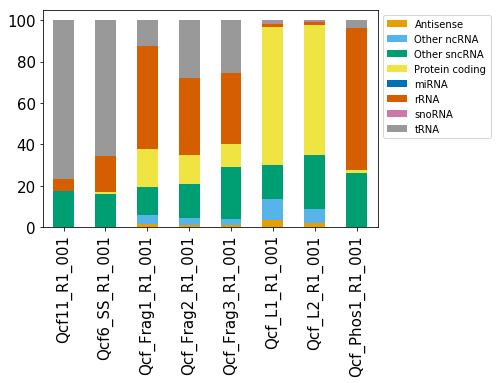

In [102]:
ax = plt.subplot(111)
long_phos\
    .pipe(lambda d: d[~d.grouped_type.isin(['No features'])]) \
    .drop(['id','name'], axis=1)\
    .groupby('grouped_type') \
    .sum() \
    .transform(lambda d: d/d.sum(axis=0) * 100) \
    .transpose()\
    .plot.bar(stacked=True, ax = ax, color = okabeito_palette())
ax.legend(bbox_to_anchor = (1,1))

Text(0.5,3.2,'')

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


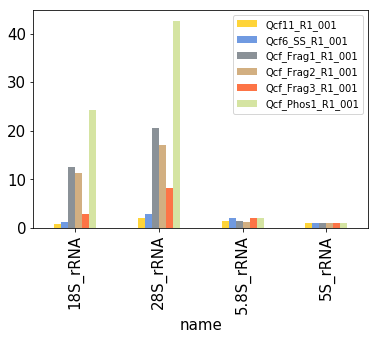

In [104]:
long_phos \
    .pipe(lambda d: d[d.columns[~d.columns.str.contains('L[12]')]])\
    .query('grouped_type == "rRNA"') \
    .set_index('name')\
    .drop(['id','grouped_type'], axis=1) \
    .transform(lambda d: d/d.loc['5S_rRNA']) \
    .plot.bar(color=simpsons_palette())
ax.set_ylabel('Enrichment (relative to 5S_rRNA)')
ax.set_xlabel('')

In [109]:
long_phos\
    .query('grouped_type=="Other sncRNA"')\
    .pipe(lambda d: d[d.iloc[:,3:].sum(axis=1)>0]) \
    .sort_values('Qcf_Phos1_R1_001', ascending=False) 

,id,grouped_type,name,Qcf11_R1_001,Qcf6_SS_R1_001,Qcf_Frag1_R1_001,Qcf_Frag2_R1_001,Qcf_Frag3_R1_001,Qcf_L1_R1_001,Qcf_L2_R1_001,Qcf_Phos1_R1_001
79908,piRNA,Other sncRNA,piR-hsa-27731,85325,49740,35523,42802,482901,626,762,219568
79907,piRNA,Other sncRNA,piR-hsa-27730,81798,49282,35117,42276,467733,576,700,214958
79905,piRNA,Other sncRNA,piR-hsa-27729,77874,48491,34994,42156,453527,564,682,212197
78548,piRNA,Other sncRNA,piR-hsa-26492,19893,4361,25596,31997,107414,35386,63328,198412
79023,piRNA,Other sncRNA,piR-hsa-26925,11358,4914,25825,31523,61986,12145,21937,174044
80429,piRNA,Other sncRNA,piR-hsa-28205,26860,7193,22554,29894,117086,14966,24740,156069
69814,piRNA,Other sncRNA,piR-hsa-1847,7652,1961,16528,20460,49902,26823,48230,118963
73149,piRNA,Other sncRNA,piR-hsa-2155,7907,1897,16280,20058,50863,26588,47778,118332
73138,piRNA,Other sncRNA,piR-hsa-2154,7550,1849,16069,19803,48489,26237,47176,115738
79904,piRNA,Other sncRNA,piR-hsa-27728,17120,5263,18913,24201,71191,6888,12050,95088
